# Forecasting Bus Demand in Banana Republic Municipalities
### Prepared by: Said Bolluk
### E-Mail: said.bolluk@ozu.edu.tr

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Display model diagram
from sklearn import set_config
set_config(display='diagram')

# 1) Data Preprocessing

In [3]:
mydf = pd.read_csv("municipality_bus_utilization.csv")
mydf.head()

,timestamp,municipality_id,usage,total_capacity
0,2017-06-04 07:59:42,9,454,1332
1,2017-06-04 07:59:42,8,556,2947
2,2017-06-04 07:59:42,4,1090,3893
3,2017-06-04 07:59:42,0,204,2813
4,2017-06-04 07:59:42,7,718,2019


Transform the "timestamp" column into a datatime object:

In [4]:
mydf["timestamp"] = pd.to_datetime(mydf["timestamp"])

In [5]:
mydf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13070 entries, 0 to 13069
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   timestamp        13070 non-null  datetime64[ns]
 1   municipality_id  13070 non-null  int64         
 2   usage            13070 non-null  int64         
 3   total_capacity   13070 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 408.6 KB


Select and save the hour, day, and month info for tHe future calculations:

In [6]:
mydf["time_hour"] = mydf.timestamp.apply(lambda x: x.hour)
mydf["time_day"] = mydf.timestamp.apply(lambda x: x.day)
mydf["time_month"] = mydf.timestamp.apply(lambda x: x.month)

In [7]:
mydf.head()

,timestamp,municipality_id,usage,total_capacity,time_hour,time_day,time_month
0,2017-06-04 07:59:42,9,454,1332,7,4,6
1,2017-06-04 07:59:42,8,556,2947,7,4,6
2,2017-06-04 07:59:42,4,1090,3893,7,4,6
3,2017-06-04 07:59:42,0,204,2813,7,4,6
4,2017-06-04 07:59:42,7,718,2019,7,4,6


Dataset contains a single or couple of recordings for each hour. Therefore, I will take the mean of these recordings for each hour.

In [8]:
municipalities = list(range(0, 10))
months = [6, 7, 8]

empty_frame = pd.DataFrame()

for i in municipalities:
    
    data_muni = mydf[mydf["municipality_id"]==i]
    
    for j in months:
        
        data_month = data_muni[data_muni["time_month"]==j]
        
        day_list = np.sort(data_month["time_day"].value_counts().index.to_list())

        for k in day_list:
            
            data_day = data_month[data_month["time_day"]==k]
            
            # Group usage per hour by averaging out the recordings in the same hour
            aggregate = data_day.groupby(by="time_hour")["usage"].mean().round(2)
            
            # Define a new data frame to keep recordings per hour
            frame = {
                "Municipality": i,
                "Month": j,
                "Day": k,
                "Hour": aggregate.index, 
                "Average Usage": aggregate.values,
            }            
            reduced_data = pd.DataFrame(frame)
            empty_frame = empty_frame.append(reduced_data, ignore_index=True)

Create a copy of the empty_frame:

In [9]:
bus_demand = empty_frame.copy()

## Missing Data Imputation

Note that recordings are kept between the same dates in each municipality. Let us examine the missing days for each month:

In [10]:
months = [6, 7, 8]
total_day = 0

for i in months:
    
    day_list = np.sort(empty_frame[empty_frame["Month"]==i]["Day"].value_counts().index.to_list())
    total_day += len(day_list)
    
    print(f"Month-{i}: {day_list}")
    print(f"Total Day: {total_day}\n")

Month-6: [ 4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 22 23 24 25 26 27 28 29
 30]
Total Day: 25

Month-7: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]
Total Day: 55

Month-8: [ 1  2  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
Total Day: 72



There are two missing days (20, 21) for the Month 6, and two missing days (3, 4) for the Month 8. The Month 7 does not contain any missing days. Lut us create a row for with the average use per hour and complete the missing days of each month:

In [11]:
municipalities = list(range(0, 10))
missing_months = [6, 8]

missing_frame = pd.DataFrame()

for i in municipalities:
    
    data_muni = bus_demand[bus_demand["Municipality"]==i]
    
    for j in missing_months:
        
        if j==6:
            missing_days = [20, 21]
        
        elif j==8:
            missing_days = [3, 4]
        
        else:
            print("ERROR!")
            
        for k in missing_days:
            
            grouping = data_muni.groupby(by="Hour")["Average Usage"].mean()
            #print(i, j, k, grouping)
            frame = {
                "Municipality": i,
                "Month": j,
                "Day": k,
                "Hour": grouping.index, 
                "Average Usage": grouping.values,
            }            
            missing_data = pd.DataFrame(frame)
            missing_frame = missing_frame.append(missing_data, ignore_index=True)
            
final_df = pd.concat([bus_demand, missing_frame], axis=0, ignore_index=True)

In [12]:
print("Missing:", bus_demand.shape)
print("Completed:", final_df.shape)

Missing: (6740, 5)
Completed: (7140, 5)


Check if there are any missing days:

In [13]:
months = [6, 7, 8]

for i in months:
    
    day_list = np.sort(final_df[final_df["Month"]==i]["Day"].value_counts().index.to_list())
    
    print(f"Month-{i}: {day_list}")

Month-6: [ 4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27
 28 29 30]
Month-7: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]
Month-8: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


Sort intances by Municipality, Month, Day, and Hour. Reset the index.

In [14]:
final_df = final_df.sort_values(by=["Municipality", "Month", "Day", "Hour"], ascending = [True, True, True, True])
final_df = final_df.reset_index()
final_df = final_df.drop(columns="index")

## Feature Extraction

### Density

Insert total capacity info and create a density column: Average Usage/Total Capacity

In [15]:
muni_id = mydf.groupby(by="municipality_id")["total_capacity"].mean().index.tolist()
capacity_list = mydf.groupby(by="municipality_id")["total_capacity"].mean().values.tolist()

for i in range(final_df.shape[0]):

    municipality = final_df.loc[i, "Municipality"]
    
    for j in range(0, 10):
        
        if municipality == muni_id[j]:
            final_df.loc[i, "Density"] = final_df.loc[i, "Average Usage"] / capacity_list[j]
            
        else:
            pass

### Date

Combine the date features and present as: Month/Day/Hour

In [16]:
for i in range(final_df.shape[0]):
    
    m, d, h = final_df.loc[i, "Month"], final_df.loc[i, "Day"], final_df.loc[i, "Hour"]
    final_df.loc[i, "Date"] = f"{m}/{d}/{h}"

### 50 Hour Moving Average

Combine each hour of recordings into a single column named **Cumulative Hours**. This will help us calculate the 50 hour moving average of usage for each recording.

In [17]:
initial_id = 0
count = 0

for i in range(final_df.shape[0]):
    
    new_id = final_df.loc[i, "Municipality"]
    
    if new_id == initial_id:
        count += 1
        final_df.loc[i, "Cumulative Hours"] = count
        
    else:
        count = 1
        final_df.loc[i, "Cumulative Hours"] = count
        
    initial_id = new_id

Calculate 50 Day Moving Average for each recording using the Cumulative Hours column:

In [18]:
municipalities = list(range(0, 10))

average_frame = pd.DataFrame()
average_list = list()

for i in municipalities:
    
    filtered = final_df[final_df["Municipality"]==i].reset_index()
    
    for j in range(filtered.shape[0]):
        
        if j < 50:
            
            mean = np.mean(filtered.loc[j:0:-1, "Average Usage"].values)
            average_list.append(mean)
            
        else:
            mean = np.mean(filtered.loc[j:j-50:-1, "Average Usage"].values)
            average_list.append(mean)

# Create a new column called "50 Hour Moving Average" with the average list          
final_df["50 Hour Moving Average"] = average_list

We will sort the final_df according to the month and day columns since the added rows disturbed the order of the original frame. We will then save the dataset to a new CSV file so we can use it quickly in the future:

In [19]:
# Sort values
final_df = final_df.sort_values(by=["Municipality", "Month", "Day", "Hour"], ascending = [True, True, True, True])

# Re-order columns and round values
final_df = final_df[['Date', 'Month', 'Day', 'Hour', 'Municipality','Average Usage', 'Density', 'Cumulative Hours', '50 Hour Moving Average']].round(2)

# Save the dataset
final_df.to_csv("ready_data.csv", index=False)

In [20]:
final_df.sample(10)

,Date,Month,Day,Hour,Municipality,Average Usage,Density,Cumulative Hours,50 Hour Moving Average
2670,7/30/12,7,30,12,3,1576.0,0.82,529.0,1154.76
798,6/12/16,6,12,16,1,282.0,0.71,85.0,267.13
3709,6/18/16,6,18,16,5,133.0,0.23,140.0,173.89
1663,6/28/15,6,28,15,2,575.5,0.83,236.0,500.82
6047,7/9/12,7,9,12,8,1197.5,0.41,336.0,921.73
4799,7/29/8,7,29,8,6,625.0,0.20,516.0,966.98
3519,8/14/14,8,14,14,4,3270.0,0.84,664.0,2392.66
676,8/16/7,8,16,7,0,227.0,0.08,677.0,544.33
717,6/4/10,6,4,10,1,295.0,0.74,4.0,201.00
4323,6/8/7,6,8,7,6,637.0,0.20,40.0,1051.47


Observe the correlation between the target and features using the Pearson correlation method:

In [21]:
final_df[final_df["Municipality"]==2].corr(method="pearson")["Average Usage"]

Month                     0.073803
Day                      -0.164146
Hour                      0.560073
Municipality                   NaN
Average Usage             1.000000
Density                   0.999858
Cumulative Hours          0.024547
50 Hour Moving Average    0.191819
Name: Average Usage, dtype: float64

# 2) Model Training

In [22]:
data = pd.read_csv("ready_data.csv")

In [23]:
data.head()

,Date,Month,Day,Hour,Municipality,Average Usage,Density,Cumulative Hours,50 Hour Moving Average
0,6/4/7,6,4,7,0,204.0,0.07,1.0,204.00
1,6/4/8,6,4,8,0,289.5,0.10,2.0,246.75
2,6/4/9,6,4,9,0,457.0,0.16,3.0,316.83
3,6/4/10,6,4,10,0,558.5,0.20,4.0,377.25
4,6/4/11,6,4,11,0,605.5,0.22,5.0,422.90


Display the columns of the dataset:

In [24]:
data.columns.to_list()

['Date',
 'Month',
 'Day',
 'Hour',
 'Municipality',
 'Average Usage',
 'Density',
 'Cumulative Hours',
 '50 Hour Moving Average']

Define a dataset named bus_demand using a set of columns:

In [25]:
bus_demand = data[['Month', 'Day', 'Hour', 'Municipality', 'Average Usage', 'Density', 'Cumulative Hours', '50 Hour Moving Average']]
bus_demand.head()

,Month,Day,Hour,Municipality,Average Usage,Density,Cumulative Hours,50 Hour Moving Average
0,6,4,7,0,204.0,0.07,1.0,204.00
1,6,4,8,0,289.5,0.10,2.0,246.75
2,6,4,9,0,457.0,0.16,3.0,316.83
3,6,4,10,0,558.5,0.20,4.0,377.25
4,6,4,11,0,605.5,0.22,5.0,422.90


Try different regressors and gather the results under the report_df:

In [26]:
report_df = pd.DataFrame()

Import necessary libraries for machine learning models and regression evaluation metrics to perform time series regression over the bus_demand data:

In [27]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error

## 2.1. Linear Regression

In [28]:
# Define a regression model
linear = LinearRegression()

In [29]:
r2_list = list()
mape_list = list()

for muni_id in range(0, 10):
    
    # Train and test split as last two weeks of each municipality are for testing purposes
    mapping_data = bus_demand[bus_demand["Municipality"]==muni_id]
    test_mapping = (mapping_data["Month"]==8) & (mapping_data["Day"]>=4)
    
    training_set = mapping_data[~test_mapping]
    y_train = training_set["Average Usage"]
    X_train = training_set.drop(columns=["Average Usage"])
    
    test_set = mapping_data[test_mapping]
    y_test = test_set["Average Usage"]
    X_test = test_set.drop(columns=["Average Usage"])
    
    # Train the model
    linear.fit(X_train, y_train)
    # Make predictions
    preds = linear.predict(X_test)
    
    r2 = r2_score(y_test, preds)
    r2_list.append(r2)
    mape = mean_absolute_percentage_error(y_test, preds)
    mape_list.append(mape)
    
# Calculate the mean score using metrics from each municipality
mean_r2 = np.mean(r2_list).round(4)
mean_mape = np.mean(mape_list).round(4)

lr_result = {
    "Model": "Linear Regression",
    "R2": mean_r2,
    "MAPE": mean_mape,
}

report_df = report_df.append(lr_result, ignore_index=True, sort=True)

## 2.2. Random Forest Regressor

This time we will perform a basic hyperparameter tuning for the forest model. We will analyze different tree depths and try to determine the optimal one that provides the least mean percentage error and the highest R2 Score.

In [30]:
depth_list = np.arange(1, 11)

overall_mape = list()
overall_r2 = list()

for depth in depth_list:
    
    # Define a regression model
    forest = RandomForestRegressor(
        max_depth=depth,
        random_state=42,
    )

    r2_list = list()
    mape_list = list()

    for muni_id in range(0, 10):

        # Train and test split as last two weeks of each municipality are for testing purposes
        mapping_data = bus_demand[bus_demand["Municipality"]==muni_id]
        test_mapping = (mapping_data["Month"]==8) & (mapping_data["Day"]>=4)

        training_set = mapping_data[~test_mapping]
        y_train = training_set["Average Usage"]
        X_train = training_set.drop(columns=["Average Usage"])

        test_set = mapping_data[test_mapping]
        y_test = test_set["Average Usage"]
        X_test = test_set.drop(columns=["Average Usage"])

        # Train the model
        forest.fit(X_train, y_train)
        # Make predictions
        preds = forest.predict(X_test)

        r2 = r2_score(y_test, preds)
        r2_list.append(r2)
        mape = mean_absolute_percentage_error(y_test, preds)
        mape_list.append(mape)
    
    # Calculate the mean score using metrics from each municipality
    mean_r2 = np.mean(r2_list).round(4)
    mean_mape = np.mean(mape_list).round(4)
    
    # Save the average R2 Score and MAPE for a maximum tree depth:
    overall_r2.append(mean_r2)
    overall_mape.append(mean_mape)

Use a validation curve that helps us observe the trade-off between bias (MAPE) and variance (R2) and determine the optimal tree depth.

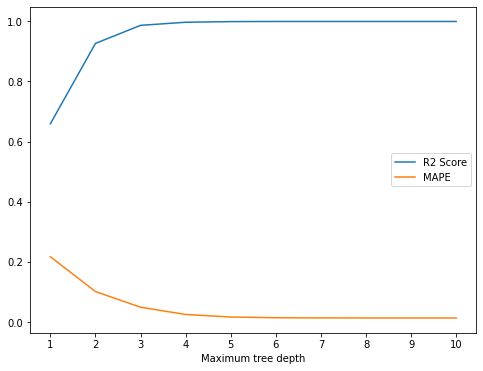

In [31]:
plt.figure(figsize=(8, 6))
plt.plot(depth_list, overall_r2, label="R2 Score")
plt.plot(depth_list, overall_mape, label="MAPE")
plt.xticks(depth_list)
plt.xlabel("Maximum tree depth")
plt.legend()
plt.show()

From the validation curve above, we can see that the optimal tree depth is **four (4)**. After this point, the result improvement slows down. We will now use this parameter value to train the Random Forest Regressor.

In [32]:
# Define a regression model
forest = RandomForestRegressor(
    max_depth=4,
    random_state=42,
)

In [33]:
r2_list = list()
mape_list = list()

for muni_id in range(0, 10):
    
    # Train and test split as last two weeks of each municipality are for testing purposes
    mapping_data = bus_demand[bus_demand["Municipality"]==muni_id]
    test_mapping = (mapping_data["Month"]==8) & (mapping_data["Day"]>=4)
    
    training_set = mapping_data[~test_mapping]
    y_train = training_set["Average Usage"]
    X_train = training_set.drop(columns=["Average Usage"])
    
    test_set = mapping_data[test_mapping]
    y_test = test_set["Average Usage"]
    X_test = test_set.drop(columns=["Average Usage"])
    
    # Train the model
    forest.fit(X_train, y_train)
    # Make predictions
    preds = forest.predict(X_test)
    
    r2 = r2_score(y_test, preds)
    r2_list.append(r2)
    mape = mean_absolute_percentage_error(y_test, preds)
    mape_list.append(mape)
    
# Calculate the mean score using metrics from each municipality
mean_r2 = np.mean(r2_list).round(4)
mean_mape = np.mean(mape_list).round(4)

forest_result = {
    "Model": "Random Forest Regressor",
    "R2": mean_r2,
    "MAPE": mean_mape,
}

report_df = report_df.append(forest_result, ignore_index=True, sort=True)

## 2.3. Gradient Boosting Regressor

This time we will perform a relatively extensive hyperparameter tuning using more than one hyperparameter.

In [34]:
from sklearn.model_selection import GridSearchCV

In [35]:
GradientBoostingRegressor().get_params()

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'squared_error',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

Select a random municipality for simplicity:

In [36]:
random_muni = 5

Perform hyperparameter tuning:

In [37]:
training_set = bus_demand[bus_demand["Municipality"]==random_muni]
y_train = training_set["Average Usage"]
X_train = training_set.drop(columns=["Average Usage"])

# Initiate a regression model
gradient = GradientBoostingRegressor(random_state=42)

grid_params = {
    "loss": ["squared_error", "absolute_error", "huber", "quantile"],
    "criterion": ["friedman_mse", "squared_error"],
    "learning_rate": np.arange(1, 110, 10)* 1e-3,
    "max_depth": np.arange(1, 11),    
}

grid_search = GridSearchCV(gradient, grid_params, verbose=1, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 880 candidates, totalling 4400 fits


GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=42),
             n_jobs=-1,
             param_grid={'criterion': ['friedman_mse', 'squared_error'],
                         'learning_rate': array([0.001, 0.011, 0.021, 0.031, 0.041, 0.051, 0.061, 0.071, 0.081,
       0.091, 0.101]),
                         'loss': ['squared_error', 'absolute_error', 'huber',
                                  'quantile'],
                         'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])},
             verbose=1)

According to the results of GridSearch, the best score and the optimal estimation parameters are:

In [38]:
print(f"Best Score: {grid_search.best_score_:.4f}")
print("Optimal parameter combination:\n", grid_search.best_estimator_)

Best Score: 0.9967
Optimal parameter combination:
 GradientBoostingRegressor(criterion='squared_error', learning_rate=0.091,
                          max_depth=4, random_state=42)


Let us now train a regression model using the optimal setting obtained from grid search:

In [39]:
# Define a regression model
gradient = GradientBoostingRegressor(
    criterion="squared_error",
    learning_rate=0.09,
    max_depth=4,
    random_state=42,
)

In [40]:
r2_list = list()
mape_list = list()

for muni_id in range(0, 10):
    
    # Train and test split as last two weeks of each municipality are for testing purposes
    mapping_data = bus_demand[bus_demand["Municipality"]==muni_id]
    test_mapping = (mapping_data["Month"]==8) & (mapping_data["Day"]>=4)
    
    training_set = mapping_data[~test_mapping]
    y_train = training_set["Average Usage"]
    X_train = training_set.drop(columns=["Average Usage"])
    
    test_set = mapping_data[test_mapping]
    y_test = test_set["Average Usage"]
    X_test = test_set.drop(columns=["Average Usage"])
    
    # Train the model
    gradient.fit(X_train, y_train)
    # Make predictions
    preds = gradient.predict(X_test)
    
    r2 = r2_score(y_test, preds)
    r2_list.append(r2)
    mape = mean_absolute_percentage_error(y_test, preds)
    mape_list.append(mape)
    
# Calculate the mean score using metrics from each municipality
mean_r2 = np.mean(r2_list).round(4)
mean_mape = np.mean(mape_list).round(4)

gradient_result = {
    "Model": "Gradient Boosting Regressor",
    "R2": mean_r2,
    "MAPE": mean_mape,
}

report_df = report_df.append(gradient_result, ignore_index=True, sort=True)

# 3) Results and Discussion

Edit the order of columns and sort the the values:

In [41]:
report_df = report_df[["Model", "R2", "MAPE"]]
report_df = report_df.sort_values(by=["R2"], ascending=False)
report_df

,Model,R2,MAPE
0,Linear Regression,0.9995,0.0073
2,Gradient Boosting Regressor,0.9989,0.0144
1,Random Forest Regressor,0.9964,0.0253


Save the results to a CSV file:

In [42]:
report_df.to_csv("regression_results.csv")

We can see that the **linear regression model** outperformed the others in predicting the average bus demand of the given municipalities with dominance in terms of accuracy (low error) and generalization power (high R2). Let us now visualize the estimation process of this regressor by plotting the target and predicted values.

In [43]:
mapping_data = bus_demand[bus_demand["Municipality"]==5].reset_index()
date_list = list()

for i in range(mapping_data.shape[0]):
    
    m, d, h = mapping_data.loc[i, "Month"], mapping_data.loc[i, "Day"], mapping_data.loc[i, "Hour"]
    date_list.append(f"{m}/{d}/{h}")

C:\Users\User\anaconda3\envs\pytorch_p37\lib\site-packages\ipykernel_launcher.py:65: UserWarning: FixedFormatter should only be used together with FixedLocator


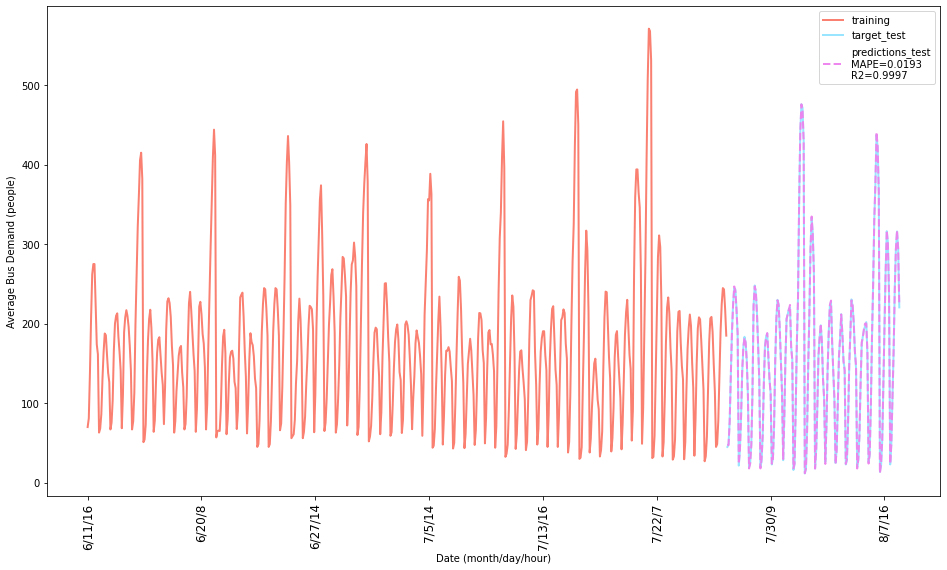

In [44]:
# Define a regression model
final_model = LinearRegression()

# Select a random municipality
random_muni = 5
    
# Train and test split as last two weeks of each municipality are for testing purposes
mapping_data = bus_demand[bus_demand["Municipality"]==random_muni].reset_index()
date_list = list()

for i in range(mapping_data.shape[0]):
    
    m, d, h = mapping_data.loc[i, "Month"], mapping_data.loc[i, "Day"], mapping_data.loc[i, "Hour"]
    date_list.append(f"{m}/{d}/{h}")

# Apply mapping to split the data into training and test sets
test_mapping = (mapping_data["Month"]==8) & (mapping_data["Day"]>=4)

training_set = mapping_data[~test_mapping]
y_train = training_set["Average Usage"]
X_train = training_set.drop(columns=["Average Usage"])

test_set = mapping_data[test_mapping]
y_test = test_set["Average Usage"]
X_test = test_set.drop(columns=["Average Usage"])

# Train the model
final_model.fit(X_train, y_train)
# Make predictions
preds = final_model.predict(X_test)
# Evaluate the regression results
r2 = r2_score(y_test, preds)
mape = mean_absolute_percentage_error(y_test, preds)

# Visualize the estimation process
fig, ax = plt.subplots(1, 1, figsize=(16, 9))
ax.plot(
    X_train.index, 
    y_train, 
    label="training",
    color="salmon",
    lw=2,
    linestyle="solid",
)
ax.plot(
    X_test.index, 
    y_test, 
    label="target_test",
    lw=2,
    color="deepskyblue",
    alpha=0.4,
    linestyle='solid',
)
ax.plot(
    X_test.index, 
    final_model.predict(X_test), 
    label=f"predictions_test\nMAPE={mape:.4f}\nR2={r2:.4f}",
    color="violet",
    alpha=0.95,
    lw=2,
    linestyle='dashed',
)
ax.set_xlabel("Date (month/day/hour)")
ax.set_ylabel("Average Bus Demand (people)")
ax.set_xticklabels(date_list[::75], rotation="vertical", fontsize=12)
ax.legend()
plt.show()

**Final Notes:** We see that our linear model performed almost perfect in estimating the average usage over the test data. High R2 score along with a low percentage error suggest that we built a strong model in terms of both accuracy and generalization capacity.

# END